In [21]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# --- 1. Data Loading and Preprocessing ---
# Sample transactional data for a retail company

df = pd.read_csv('sample_data_2.csv')

# Convert dates and calculate total price
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.dropna(subset=['CustomerID'], inplace=True)
df['CustomerID'] = df['CustomerID'].astype(int)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# --- 2. RFM Feature Engineering ---
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm_df.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'MonetaryValue'}, inplace=True)

# --- 3. Data Scaling ---
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df)
rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm_df.index, columns=rfm_df.columns)

In [23]:
# --- 4. K-Means Model Training ---
# For this assignment, we assume K=4 is optimal based on the Elbow Method
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, max_iter=300, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled_df)

# --- 5. Segment Analysis & Visualization ---
print("--- RFM Data with Clusters ---")
print(rfm_df.head())

# Calculate the average RFM values for each cluster
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

print("\n--- Cluster Summary ---")
print(cluster_summary)



--- RFM Data with Clusters ---
            Recency  Frequency  MonetaryValue  Cluster
CustomerID                                            
1001             11          3         100.38        0
1002              1          2          11.25        1
1003            209          3         147.25        0
1004            140          2          24.95        2
1005             38          2          17.82        1

--- Cluster Summary ---
        Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          84.3       3.0          97.1     3
1           8.2       1.5           9.6     6
2         212.0       2.0          19.5     3
3          62.5       2.0         194.6     2


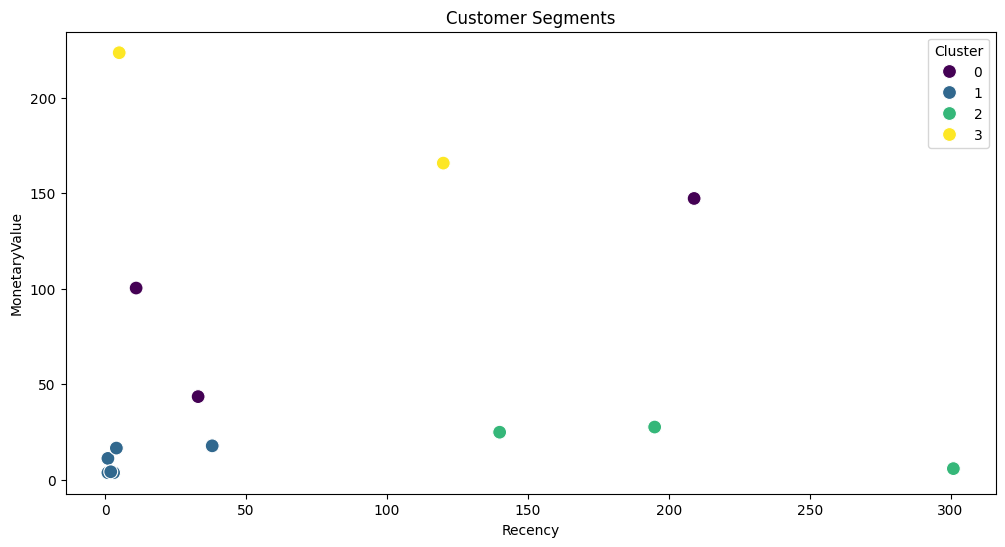

In [24]:
# Visualize the clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(data=rfm_df, x='Recency', y='MonetaryValue', hue='Cluster', palette='viridis', s=100)
plt.title('Customer Segments')
plt.show()